# To be continued or discontinued: investigating secret formula for successful movie franchise
This notebook contains in-depth analysis and visualization for our project. Some figures in the blog post is taken from this notebook.

## Data loading and preprocessing

__Delete unused import before submission__

In [15]:
%load_ext autoreload
%autoreload 2
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

# custom functions
from src.data.utils import get_franchise_movies, get_inflation_rate, get_movie, clean_character_metadata, custom_autopct, create_ethnicity_columns, get_tree_df, get_genre_counts, get_franchise_data, clean_categories
from src.utils.plotting import plot_geo_piecharts
from src.utils.importance import run_importance
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We'll start by loading the character data and drop rows if any of the columns in `COL_FOR_DROPNA` is missing. This will make the following analysis easier without dropping too many rows (55467/395202 dropped).

__DO NOT EDIT THE LOADING ORDER OF `character_df`, `movies_df_raw`, `franchise_df` AND `movies_no_franchise_df`.__

In [2]:
COL_NAMES = [
    'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 
    'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m', 'Actor_ethnicity_Freebase_ID', 
    'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 'Freebase_actor_ID'
]
COL_FOR_DROPNA = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date',
                  'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID',
                  'Freebase_actor_ID']
RANDOM_STATE = 42

In [3]:
# load and prepare character_df
character_df = pd.read_csv('data/character.metadata.tsv', names=COL_NAMES, sep='\t')
character_df = clean_character_metadata(character_df, mapping_path='data/ethnicity_mapping.csv', columns=COL_FOR_DROPNA)

#loading the inflation rate data set from the columbia bank
inflation_rate_df=get_inflation_rate()
#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')
movies_df_raw = create_ethnicity_columns(movies_df_raw, character_df)
#Data frame with all the movies with preprocessing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')
#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

# create a new column to check if the movie is part of a franchise
character_df["is_in_franchise"] = character_df["Wikipedia_movie_ID"].isin(franchise_df["Wikipedia movie ID"])

#Data frame of only the franchise name and their characteristics
# franchise_data_df = get_franchise_data(franchise_df)

# Drop franchises where any movie in the franchise does not have a release date
# franchise_df_2 = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
# print("Number of movies with all movies having release dates : ", len(franchise_df_2))
# print(franchise_df)

Dropping character data rows with missing values in any of ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID', 'Freebase_actor_ID'].
Number of rows dropped: 55467
395202 rows remaining.
Running sentiment analysis...


100%|██████████| 52034/52034 [00:04<00:00, 12108.02it/s]


## First look of the data

In [4]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")
print(f"Number of movies in the entire data set: {len(movies_df['collection_id'])}")
print(f"Number of movies not in a collections: {len(movies_no_franchise_df)}")


count    1592.00000
mean        3.24309
std         3.75448
min         2.00000
25%         2.00000
50%         2.00000
75%         3.00000
max        66.00000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5163
Number of movies in the entire data set: 81740
Number of movies not in a collections: 75558


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).


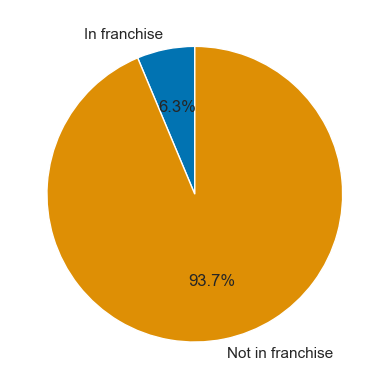

In [5]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

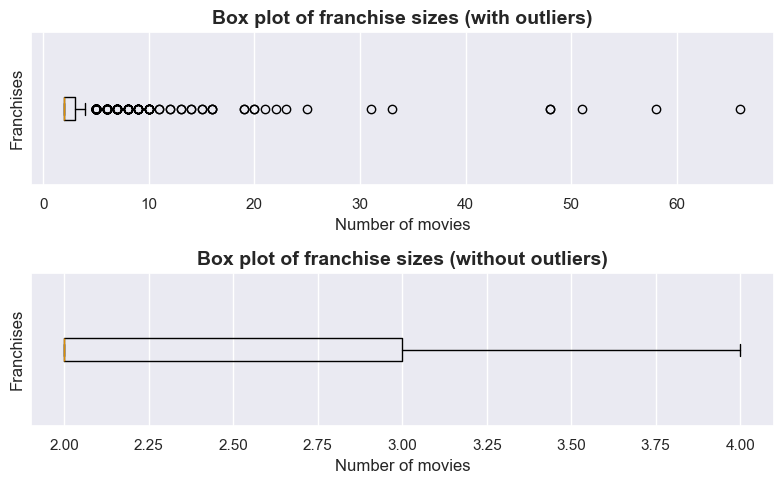

In [6]:
# Plot the box plot
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# Boxplot with outliers
axes[0].boxplot(franchise_counts, vert=False)
axes[0].set_title('Box plot of franchise sizes (with outliers)',
                  fontweight='bold', fontsize=14)
axes[0].set_xlabel('Number of movies')
axes[0].set_ylabel('Franchises')
axes[0].set_yticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, vert=False, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)',
                  fontweight='bold', fontsize=14)
axes[1].set_xlabel('Number of movies')
axes[1].set_ylabel('Franchises')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

## Univariate Analysis 

In this part we've investigated each column of the dataset and visualized what we are working with and compared movie in franchise and movie that aren't.

### Genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies. 

N.B.: most movies are defined by multiple genres and not a unique one

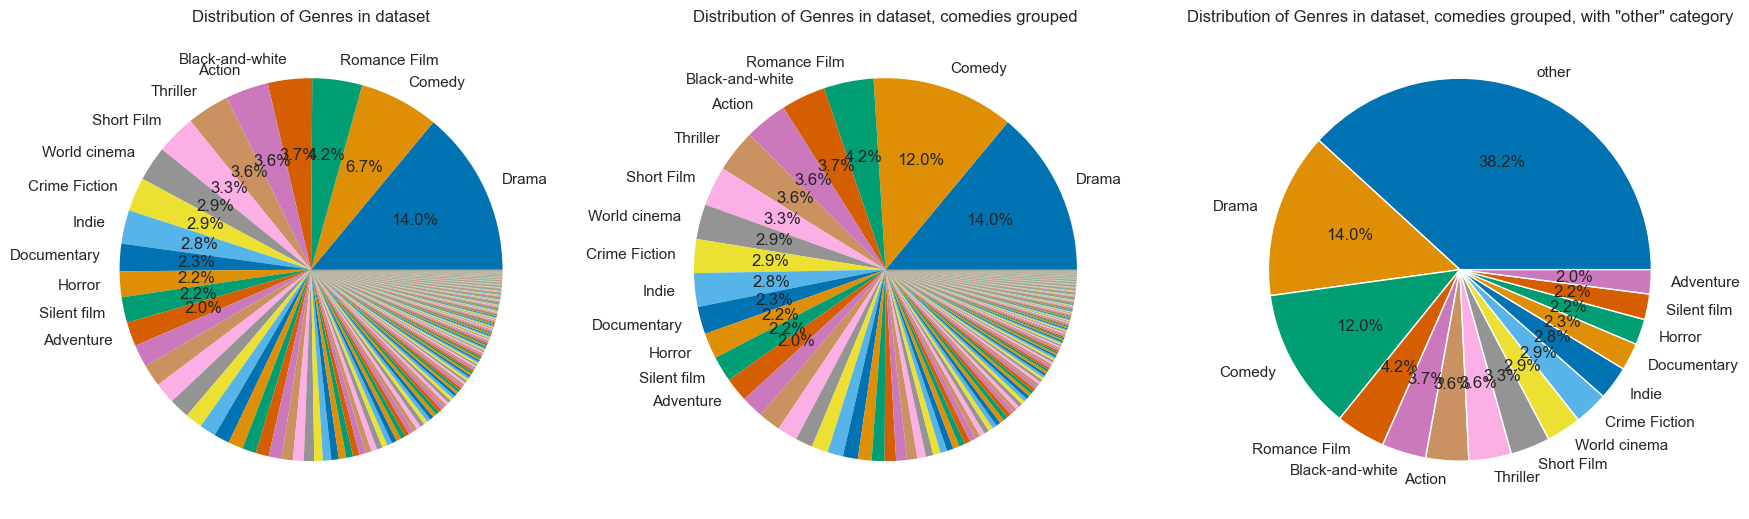

In [7]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(movies_df_raw)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

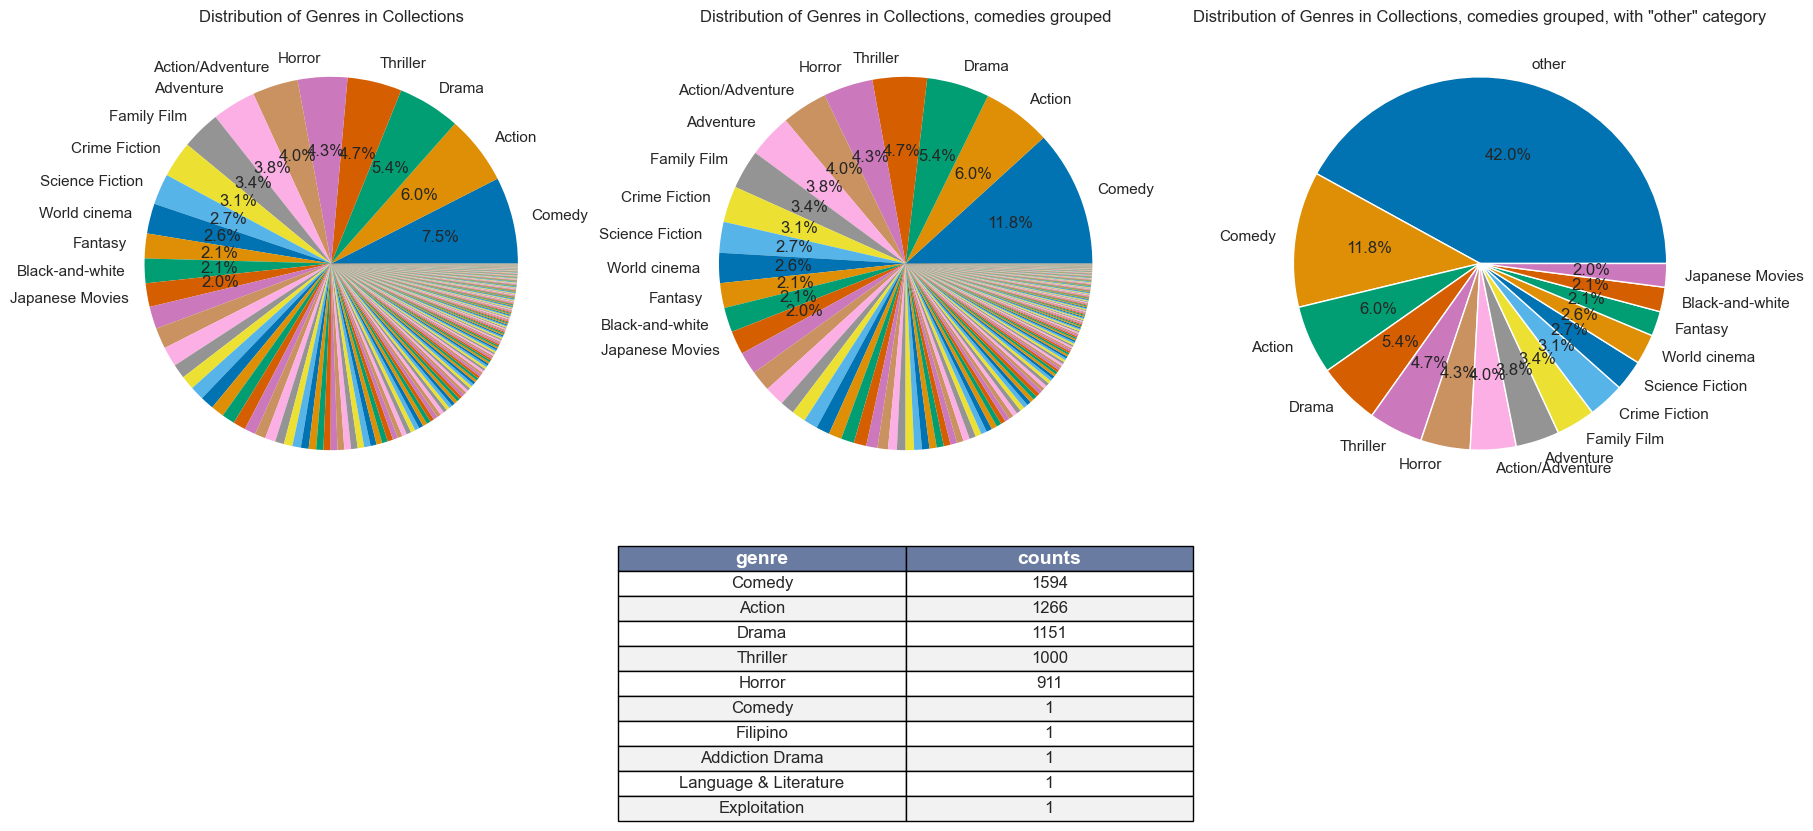

In [8]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(franchise_df)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

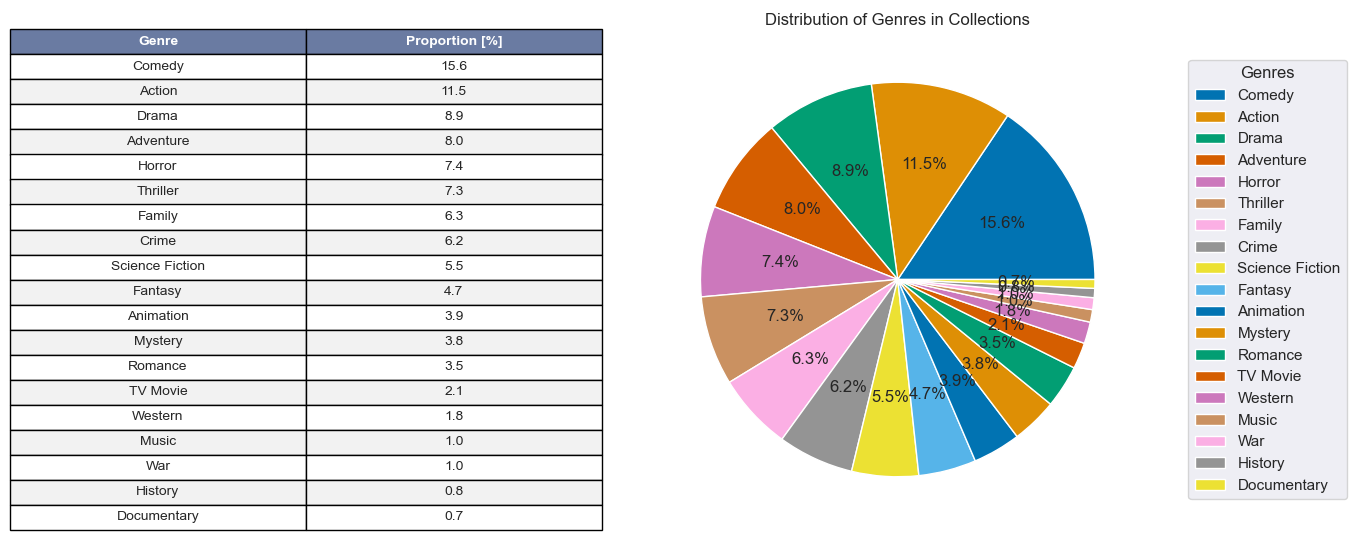

In [9]:
# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

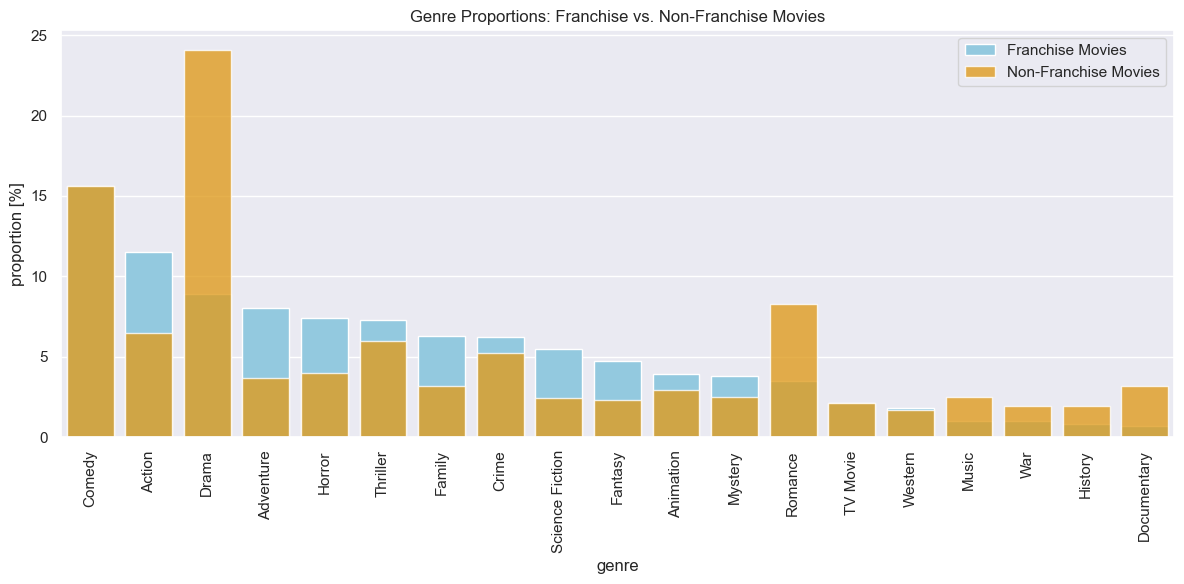

In [10]:
# Extract genres proportions for movies not in franchise, as done before
nf_flattened_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()

### Time representation

For this part we used the released date as the main variable to analyze first the movies in the franchise collection and then the franchise as a whole

#### Distribution of the release year of movies in a franchise vs the whole CMU dataset

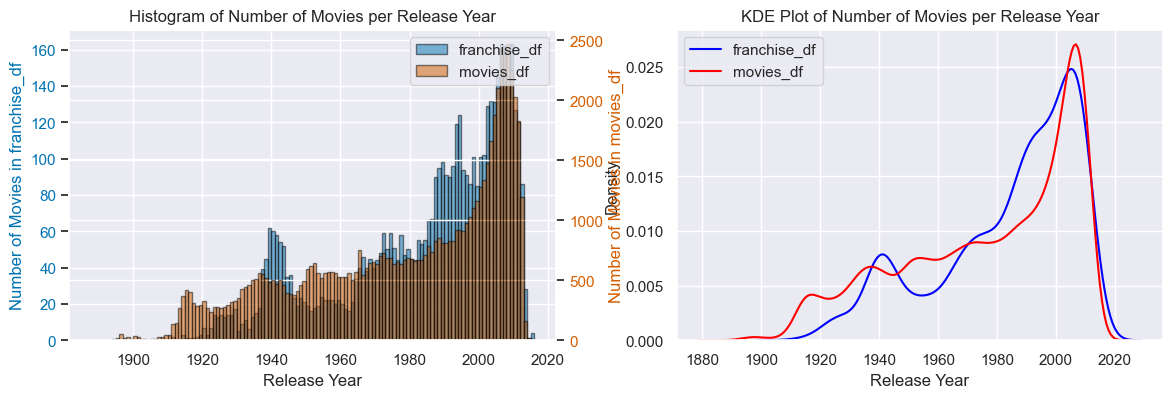

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))

# Plot the histogram for franchise_df
ax[0].hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax[0].set_xlabel('Release Year')
ax[0].set_ylabel('Number of Movies in franchise_df', color='b')
ax[0].tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax[0].twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax[0].transAxes)


# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax[1], label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax[1], label='movies_df', color='red')

# Set labels and title
ax[1].set_xlabel('Release Year')
ax[1].set_ylabel('Density')
ax[1].set_title('KDE Plot of Number of Movies per Release Year')
ax[1].legend()

plt.show()

We observe that the subset we created from the CMU Movie dataset by extracting the franchise of at least 2 movies has more or less the same distribution of release year. Note that the CMU Movie dataset has 8% missing date. The franchise one has none since it is really necessary to know the order of the movie in a franchise, the missing release date missing were recovered.

#### Franchise length and movie release frequency

The franchise_data_df is the dataframe of all the franchise and add the different characteristics: total revenue (if all the movie have a revenue), average vote of the franchise, number of movies, oldest movie release date of the franchise, most recent release date of the franchise, length and average time between the movies in a franchise.

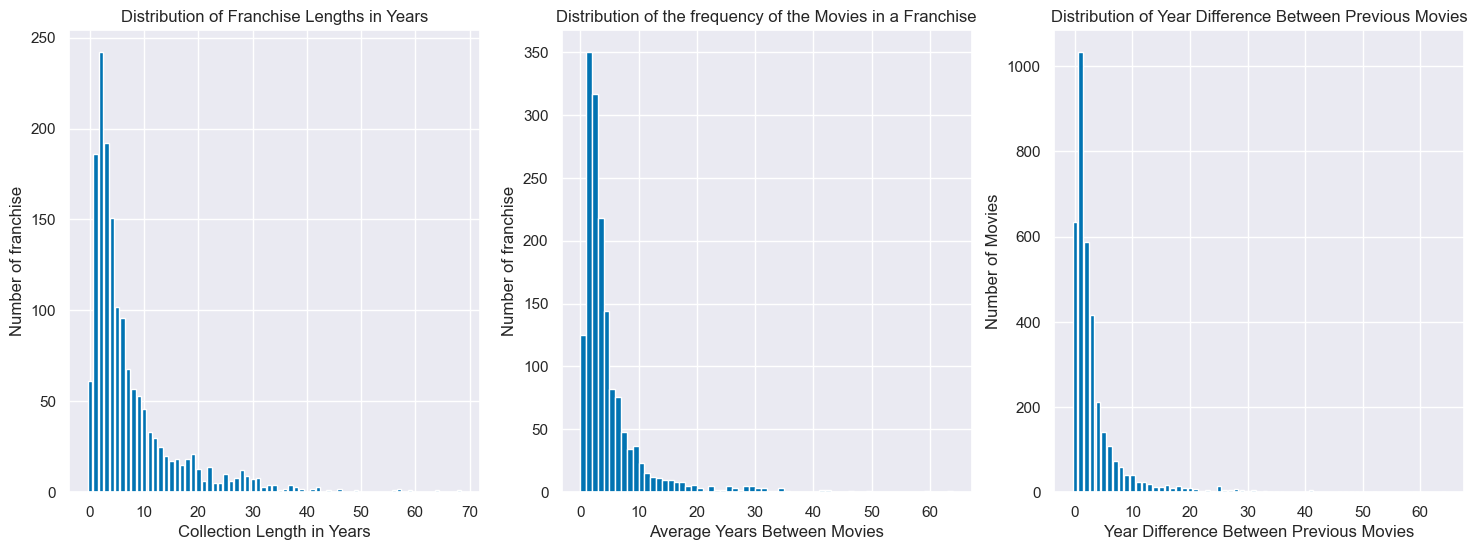

In [12]:
#Data frame of only the franchise name and their characteristics
franchise_data_df = get_franchise_data(franchise_df)

# Count the number of franchise with the same length
franchise_data_df_length = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_length.columns = ['franchise_length_years', 'count']

# Count the number of franchise with the same average years between movies
franchise_data_df_avbm = franchise_data_df['average_years_bt_movies'].value_counts().reset_index()
franchise_data_df_avbm.columns = ['average_years_bt_movies', 'count']
# Create bins for each year
bins = np.arange(franchise_data_df_avbm['average_years_bt_movies'].min(), franchise_data_df_avbm['average_years_bt_movies'].max() + 1, 1)

# Count the number of movie with the same year gap between the previous movie
franchise_df_ydbpm = franchise_df['years_diff_bt_pre_movies'].value_counts().reset_index()
franchise_df_ydbpm.columns = ['years_diff_bt_pre_movies', 'count']


# Plotting the bar chart
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].bar(franchise_data_df_length['franchise_length_years'], franchise_data_df_length['count'])
ax[0].set_xlabel('Collection Length in Years')
ax[0].set_ylabel('Number of franchise')
ax[0].set_title('Distribution of Franchise Lengths in Years')

ax[1].hist(franchise_data_df['average_years_bt_movies'], bins=bins, edgecolor='white')
ax[1].set_xlabel('Average Years Between Movies')
ax[1].set_ylabel('Number of franchise')

ax[1].set_title('Distribution of the frequency of the Movies in a Franchise')

ax[2].bar(franchise_df_ydbpm['years_diff_bt_pre_movies'], franchise_df_ydbpm['count'])
ax[2].set_xlabel('Year Difference Between Previous Movies')
ax[2].set_ylabel('Number of Movies')
ax[2].set_title('Distribution of Year Difference Between Previous Movies')
#ax[2].set_yscale('log') #jsp si cest une bonne idée
plt.show()

In [13]:
# outsiders

#franchise of more thatn 20 years
long_franchise = franchise_data_df[franchise_data_df['franchise_length_years'] > 20]
print(long_franchise['collection_name'])

#franchise witha an average of more than 15 years between movies
long_average = franchise_data_df[franchise_data_df['average_years_bt_movies'] > 15]
print(long_average['collection_name'])


0                   Star Wars Collection
1               Indiana Jones Collection
11                   Predator Collection
16             The Terminator Collection
19                 James Bond Collection
                      ...               
1535          Lupin The Third Collection
1556      Goin' Down the Road Collection
1568                             Khiladi
1574                Samrajyam Collection
1586    The Snake King's Wife Collection
Name: collection_name, Length: 128, dtype: object
57              The Space Odyssey Series
85       An American Werewolf Collection
123            Drunken Master Collection
145             Burnt by the Sun Trilogy
207               Wall Street Collection
                      ...               
1496                 Tom Cody Collection
1498       Debbie Does Dallas Collection
1556      Goin' Down the Road Collection
1574                Samrajyam Collection
1586    The Snake King's Wife Collection
Name: collection_name, Length: 82, dtype: object

We observe that the vast majority of the franchise are in a close range with still pretty big range. We're going to use this parameter to describe the franchise in a following part.

### Countries repartition

Now, we want to focus on the franchises' countries of origin (using the tmdb dataset), and look at how they interact. First we plotted a pie chart to get a first look at which countries are most respresented in the dataset.

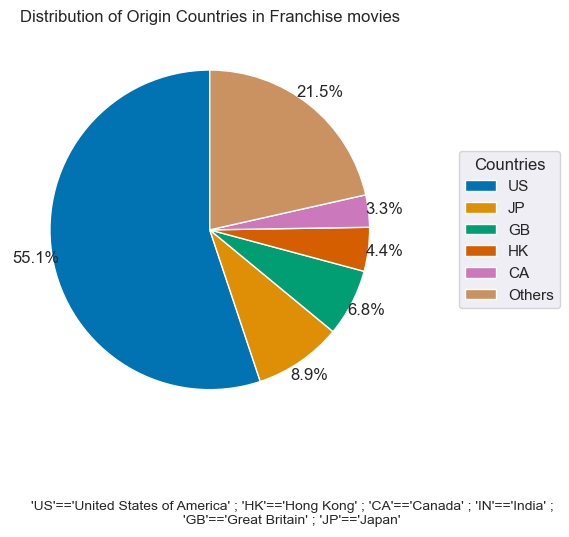

In [16]:
# Initialize a defaultdict to hold category sums
country_sums = defaultdict(int)

# Iterate over the rows of the DataFrame
for _, row in franchise_df.iterrows():
    # Clean the categories
    origin_country_new = clean_categories(row['tmdb_origin_country'])
    # Increment the count for each category
    for country in origin_country_new:
        country_sums[country] += 1

# Convert the defaultdict to a DataFrame
country_count = pd.Series(country_sums)

# Only keep countries with more than 10 movies
others=country_count[country_count<150].sum()
country_count=country_count[country_count>=150]
country_count['Others']=others

# Plot the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(country_count, autopct='%1.1f%%', pctdistance=1.1, startangle=90)
ax.legend(wedges, country_count.index, title="Countries", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Distribution of Origin Countries in Franchise movies')
# Add the text under the pie chart
info_text = "'US'=='United States of America' ; 'HK'=='Hong Kong' ; 'CA'=='Canada' ; 'IN'=='India' ; 'GB'=='Great Britain' ; 'JP'=='Japan'"
fig.text(0.5, 0.01, info_text, ha='center', va='center', fontsize=10, wrap=True)
plt.tight_layout()
plt.show()


Franchise Country Counts:
US        3166
JP         511
GB         391
HK         255
CA         187
Others    1234
dtype: int64

Movies Country Counts:
US        39255
JP         2283
GB         6606
HK         1203
CA         1984
Others    27934
dtype: int64


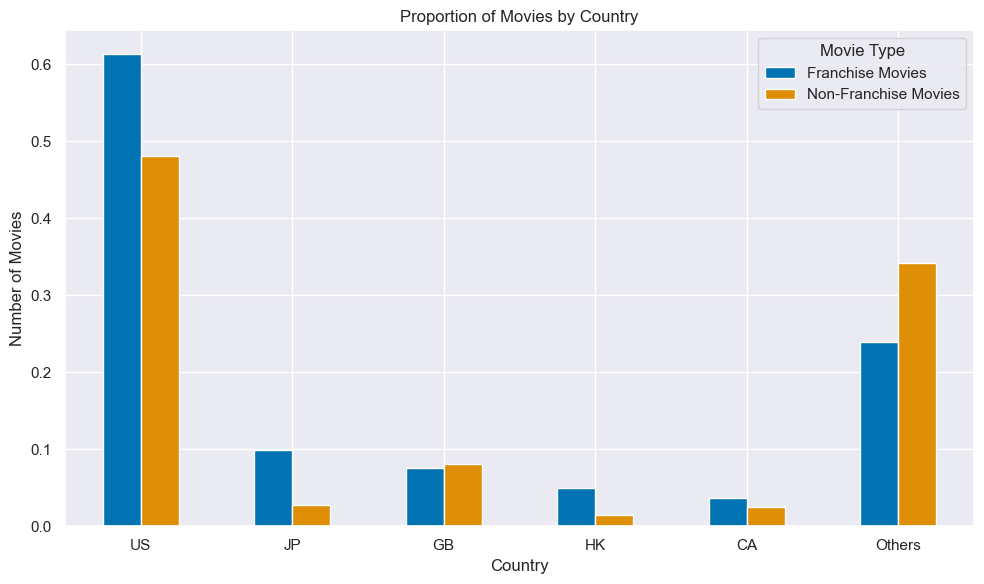

In [17]:
# Define the categories of interest
categories_of_interest = ['US', 'JP', 'GB', 'HK', 'CA']
category_labels = categories_of_interest + ['Others']

# Process the second DataFrame (movies_df)
movies_2 = movies_df.dropna(subset=['tmdb_origin_country'])
country_sums_2 = defaultdict(int)

# Iterate over the rows of the DataFrame for movies
for _, row in movies_2.iterrows():
    # Clean the categories
    origin_country_new_2 = clean_categories(row['tmdb_origin_country'])
    # Increment the count for each category
    for country in origin_country_new_2:
        if country in categories_of_interest:
            country_sums_2[country] += 1
        else:
            country_sums_2['Others'] += 1

# Convert the defaultdict to a DataFrame
movies_country_count = pd.Series(country_sums_2, index=category_labels).fillna(0)

# Output the counts for both dataframes
print("Franchise Country Counts:")
print(country_count)

print("\nMovies Country Counts:")
print(movies_country_count)


# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Franchise Movies': country_count/len(franchise_df),
    'Non-Franchise Movies': movies_country_count/len(movies_df)
})

# Plot the bar plot
data.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Movies by Country')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=0)
#plt.yscale('log')
plt.legend(title='Movie Type')
plt.tight_layout()
plt.show()



Now, let's look at how they interact: the nodes in the plot below represent how often the country is the origin of a movie, and the edges indicate that two countries are listed together as the origin countries.

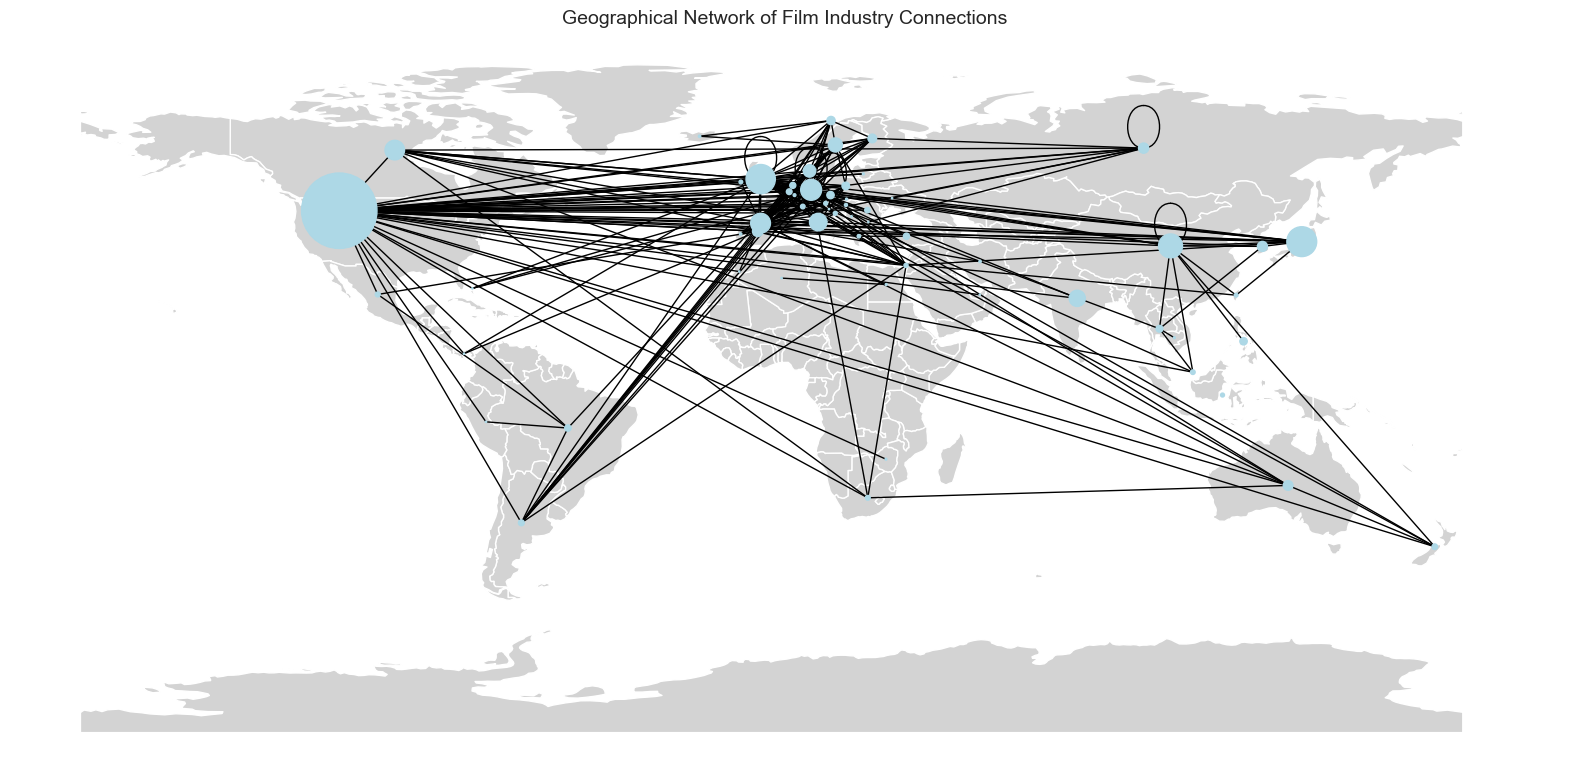

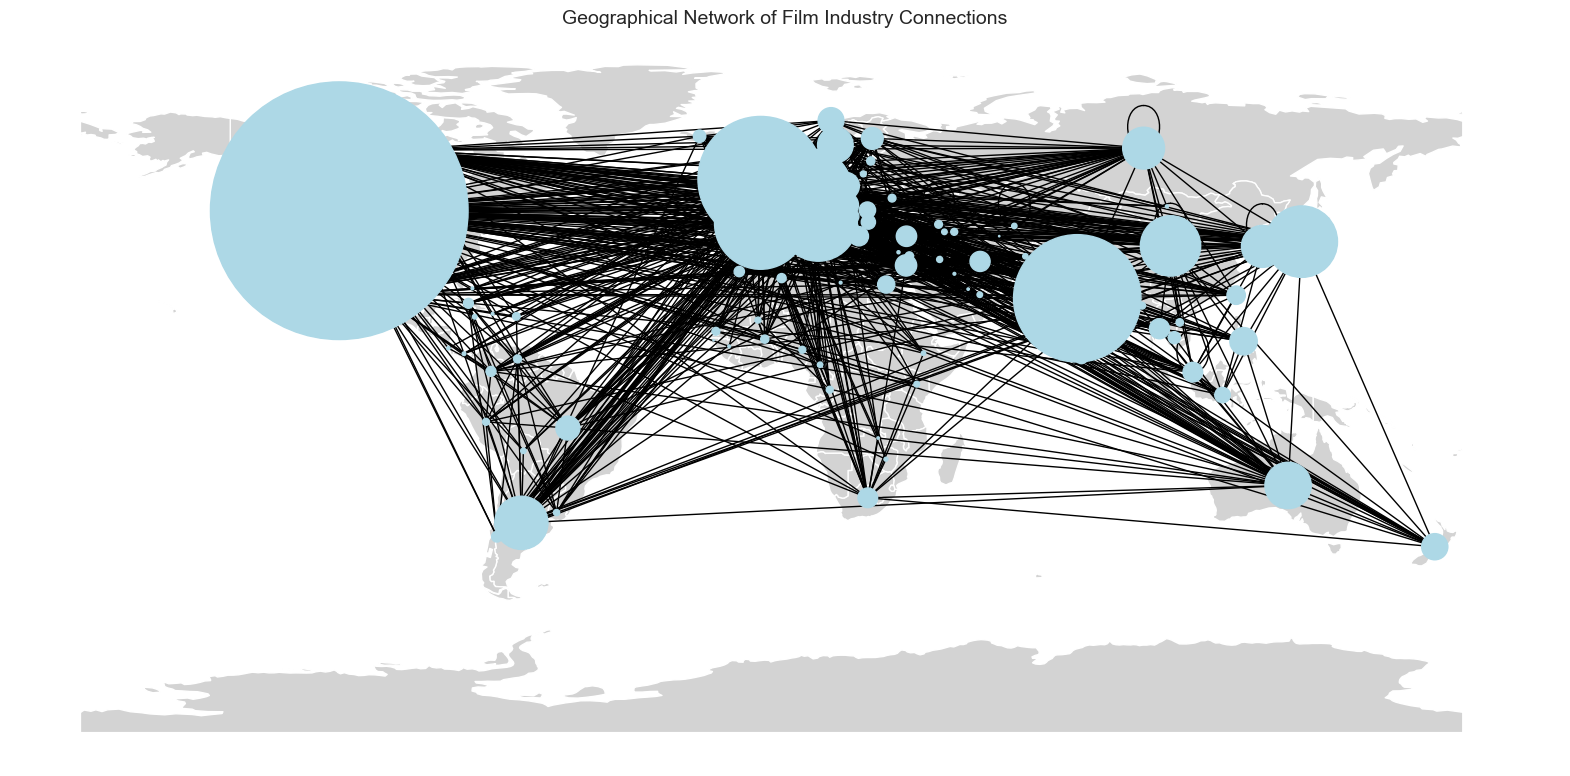

In [19]:
from src.utils.plotting import plot_network

plot_network(franchise_df)

# Filter out 'Republic of Macedonia' from movies_df before plotting
#filtered_movies_df = movies_df[movies_df['tmdb_origin_country'] != 'Republic of Macedonia']
# Check if filtering works as expected
#print('Republic of Macedonia' not in filtered_movies_df['tmdb_origin_country'].values, "Filtering did not remove 'Republic of Macedonia'.")
plot_network(movies_df)

### Actor identity analysis

In this part, we will particularly tackle Q2-3 of our research questions. That is:

> 2-3: Do actors of certain ethnicity/gender groups appear more or less commonly in franchise movies? Are they depicted positively (hero/heroine) or negatively (villain) in the movie?

#### Actor gender distribution
To begin with, we'll look at actor gender distribution of franchise and non-franchise movies.

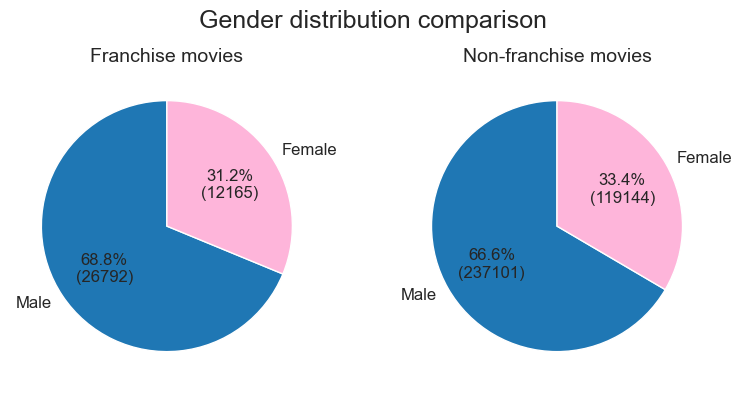

In [97]:
# Calculate the proportion of each gender for character_df
gender_proportion_non_fr = character_df[~character_df['is_in_franchise']]['Actor_gender'].value_counts()
# Calculate the proportion of each gender for fr_character_df
gender_proportion_franchise = character_df[character_df["is_in_franchise"]]['Actor_gender'].value_counts()
# Plot the gender proportions as pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Plot for fr_character_df
gender_proportion_franchise.plot(kind='pie', ax=axes[0], autopct=custom_autopct(gender_proportion_franchise),
                                 startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'],
                                 fontsize=12)
axes[0].set_ylabel('')
axes[0].set_title('Franchise movies', fontsize=14)

# Plot for character_df
gender_proportion_non_fr.plot(kind='pie', ax=axes[1], autopct=custom_autopct(gender_proportion_non_fr),
                           startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'], fontsize=12)
axes[1].set_ylabel('')
axes[1].set_title('Non-franchise movies', fontsize=14)
# Set overarching title
fig.suptitle('Gender distribution comparison', fontsize=18)
plt.tight_layout()
plt.show()

It seems that actor gender distribution remains the same for franchise and non-franchise movies. This is unsurprising as most of us can agree that there are particulalry many female characters in franchise movies than non-franchise movies, at least anecdotally.

#### Racial group
Next, we shift our focus to ethnicity groups. Contrary to actor gender information, actor ethnicity is not available for the majority of actors (available for 99719/395202 $\approx$ 25.2%). Upon observing the dataset, we hypothesized that the actors with known ethnicity are those with more publicity and therefore, more likely to play main roles in the movies. The ethnicity distribution of these main actors can be representative of which racial group is more or less featured in the movie. Bearing this in mind, we will proceed to visualize actors' racial group distribution for franchise and non-franchise movies.

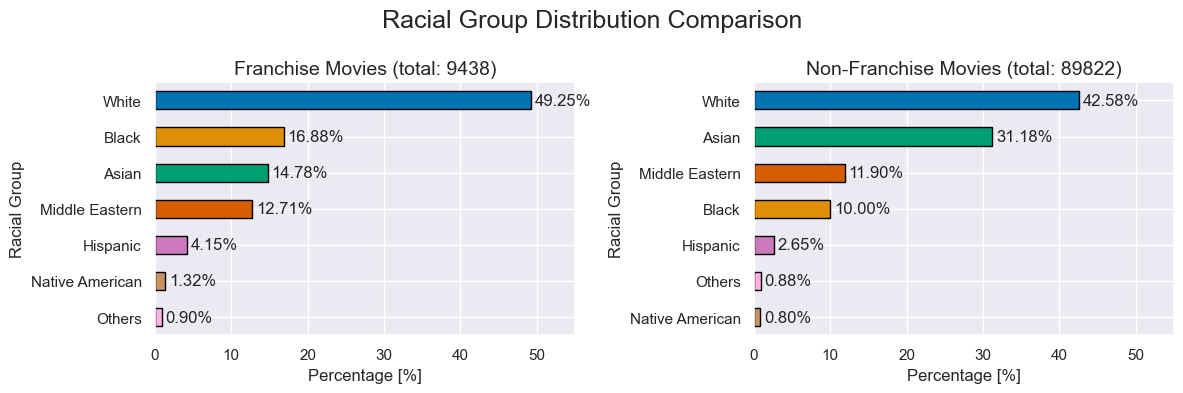

In [98]:
# Define colors for racial groups
colors = dict(zip(['White', 'Black', 'Asian', 'Middle Eastern', 'Hispanic', 'Native American', 'Others'], sns.color_palette("colorblind", 7)))

# Calculate the percentage of each racial group for franchise and non-franchise movies
racial_proportion_franchise = character_df[character_df["is_in_franchise"]].value_counts("racial_group")
racial_proportion_non_franchise = character_df[~character_df['is_in_franchise']].value_counts("racial_group")
percentage_fr = (racial_proportion_franchise / racial_proportion_franchise.sum()) * 100
percentage_non_fr = (racial_proportion_non_franchise / racial_proportion_non_franchise.sum()) * 100
fr_count = racial_proportion_franchise.sum()
non_fr_count = racial_proportion_non_franchise.sum()

# Plot the racial percentages as horizontal bar charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for franchise movies
bars_fr = percentage_fr.plot(kind='barh', ax=axes[0], color=[colors[group] for group in percentage_fr.index], edgecolor='black')
axes[0].set_title(f'Franchise Movies (total: {fr_count})', fontsize=14)
axes[0].set_xlabel('Percentage [%]')
axes[0].set_ylabel('Racial Group')
axes[0].invert_yaxis()  # Inverse y-axis
axes[0].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_fr.patches:
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

# Plot for non-franchise movies
bars_non_fr = percentage_non_fr.plot(kind='barh', ax=axes[1], color=[colors[group] for group in percentage_non_fr.index], edgecolor='black')
axes[1].set_title(f'Non-Franchise Movies (total: {non_fr_count})', fontsize=14)
axes[1].set_xlabel('Percentage [%]')
axes[1].set_ylabel('Racial Group')
axes[1].invert_yaxis()  # Inverse y-axis
axes[1].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_non_fr.patches:
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center', fontsize=12)

# Set overarching title
fig.suptitle('Racial Group Distribution Comparison', fontsize=18)

plt.tight_layout()
plt.show()

The percentages in each of the plots above sum up to 100%. Notice that compared to non-franchise movies, franchise movies have fewer percentage of Asian actors (Franchise: 14.78%, Non-franchise: 31.18%). The two pie charts on the righthand side of the figure below, however, show that the proporitions of movies from Asia (excluding Russia, Oceania and Middle East) in franchise and non-franchise movies are not as different as the disparity observed earlie in Asian actor percentages.

This means that the disparity in the percentage of Asian actors comes from factors other than the movie production location. It is hard to identify the exact cause for this from our analysis only, but a potential confounding factor can be difference in genres: perhaps certain movie genres are more likely to be franchised which are underrepresented by Asian actors.

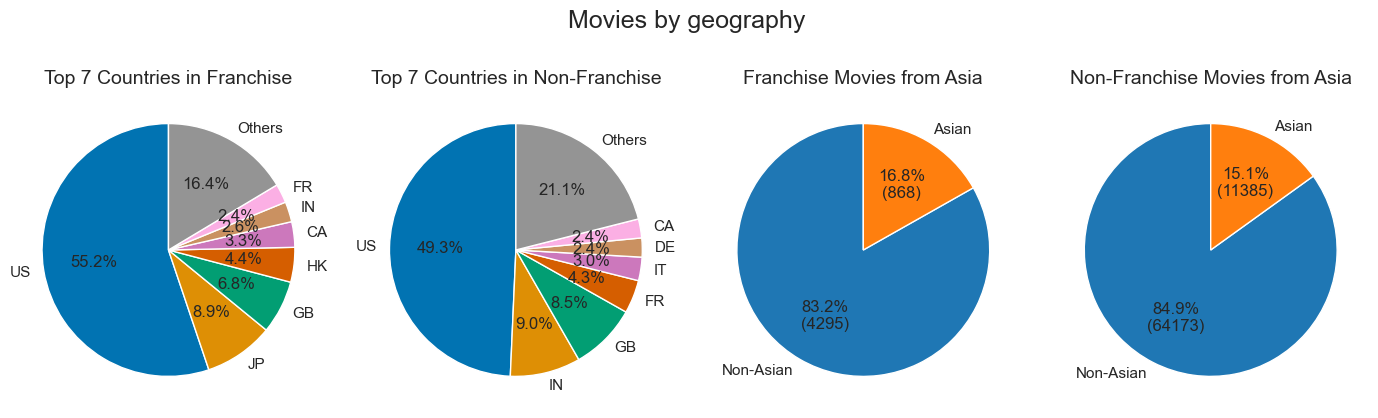

In [99]:
plot_geo_piecharts(movies_df, franchise_df, movies_no_franchise_df)

#### Sentimental analysis

Comment for word cloud - what are the typical adjectives used to positively or negatively describe the character?

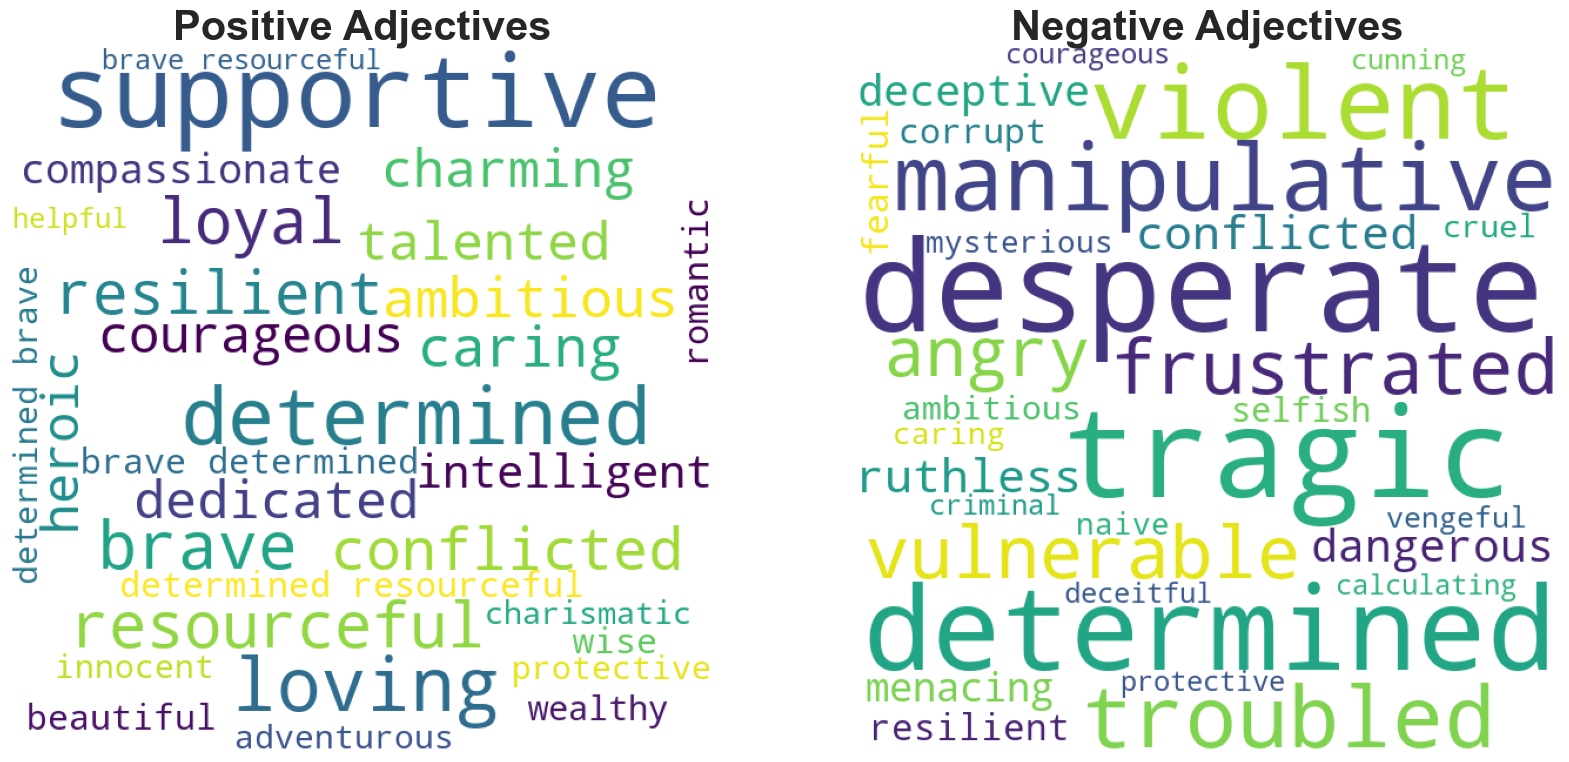

In [100]:
# Generate text for positive and negative sentiment scores
positive_text = ",".join(character_df[character_df.sentiment_score > 0.1].Adjectives)
negative_text = ",".join(character_df[character_df.sentiment_score < -0.1].Adjectives)

# Create word clouds
positive_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(positive_text)
negative_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(negative_text)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(positive_wordcloud)
axes[0].set_title('Positive Adjectives', fontsize=30, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud)
axes[1].set_title('Negative Adjectives', fontsize=30, fontweight='bold')
axes[1].axis('off')

plt.show()


Box plot - no racial group stands out in terms of distribution.

<Figure size 1200x800 with 0 Axes>

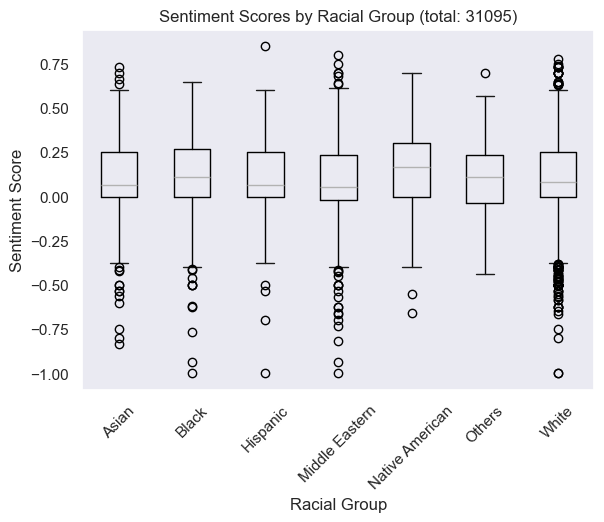

In [101]:
# Plot box plots of sentiment_score for each racial group
plt.figure(figsize=(12, 8))
character_df[character_df.is_in_franchise].dropna(subset=['sentiment_score']).boxplot(column='sentiment_score', by='racial_group', grid=False)
movie_count = len(character_df.dropna(subset=['sentiment_score']))
plt.title(f'Sentiment Scores by Racial Group (total: {movie_count})')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Racial Group')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()

## Bivariate analysis 

In this part we're going to look at the possible interaction 2 features have with another, this the first step to try to observe patterns or links.

### Movie revenue and budget 

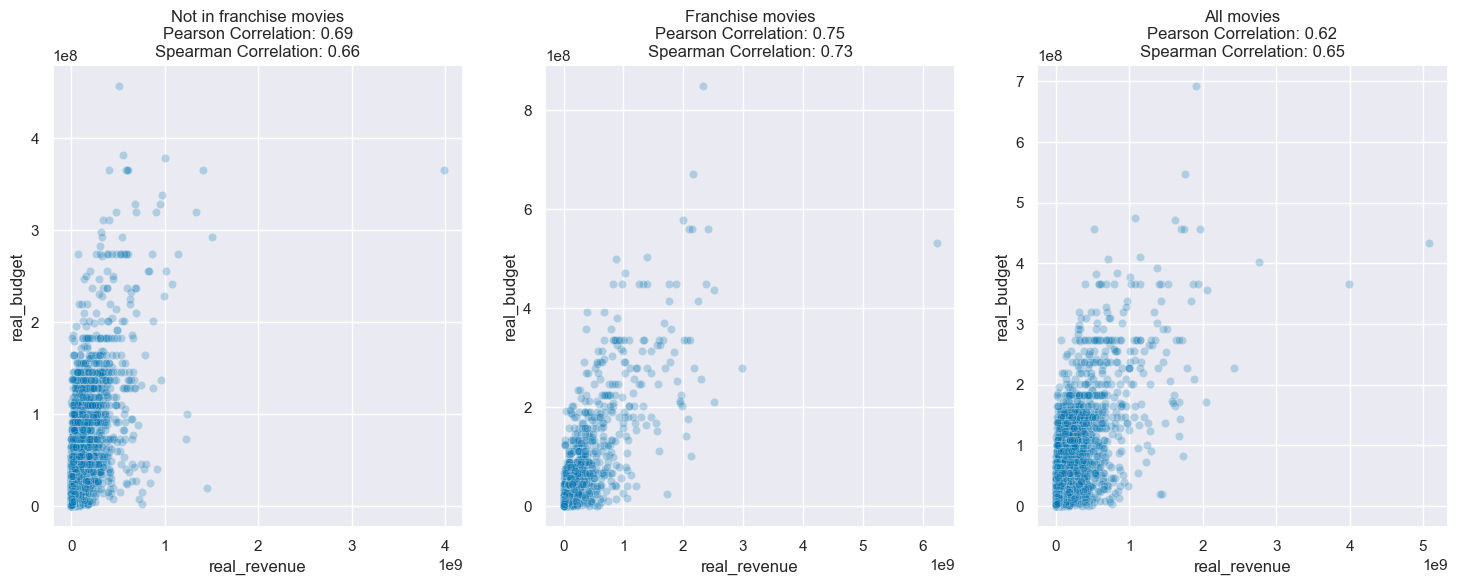

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget',data=movies_no_franchise_revenue,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=franchise_revenue,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=movies_revenue,alpha=.25, ax=axes[2])
# Calculate Pearson correlation

pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

axes[0].set_title(f'Not in franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[0,1]:.2f}')
axes[1].set_title(f'Franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[1,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[1,1]:.2f}')
axes[2].set_title(f'All movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[2,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[2,1]:.2f}');


### Genre and revenue

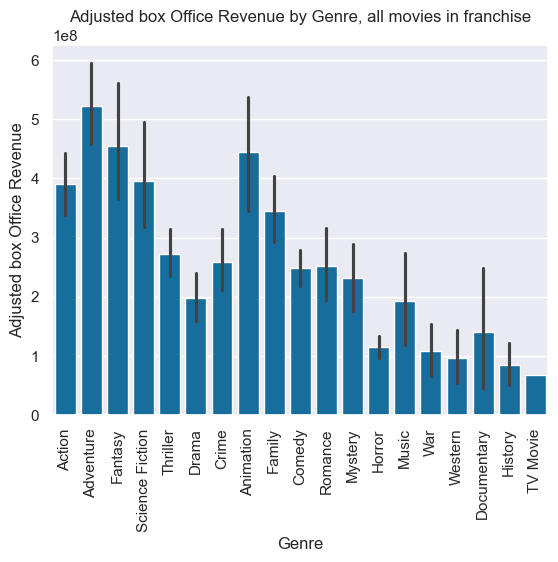

In [ ]:
# Explode the genres column so that each genre gets its own row
exploded_df = franchise_df.explode('genres').reset_index(drop=True).sort_values(by='real_revenue', ascending=False)

ax = sns.barplot(x="genres", y="real_revenue", data=exploded_df)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()
#print(exploded_df.groupby('genres')['real_revenue'].describe())

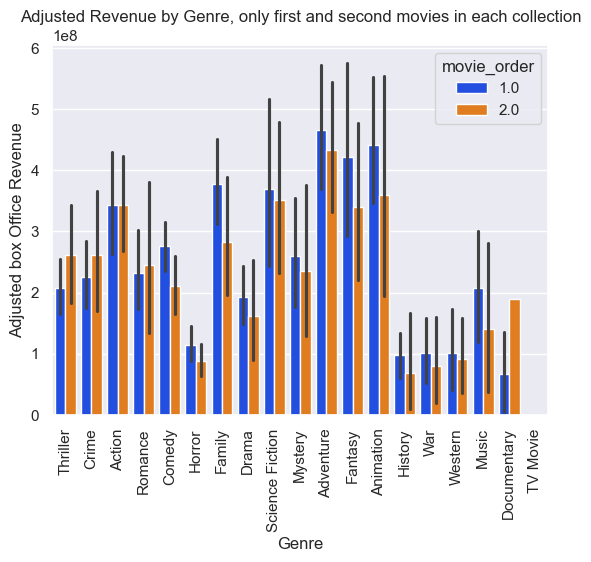

7985


In [ ]:
f_and_s = exploded_df[exploded_df['movie_order'].isin([1.0, 2.0])] # First and second movies in each collection
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s.sort_values(by='real_revenue', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()
print(len(f_and_s))

Here, we notice that TV Movies don't have a barplot, as only one movie in a franchise has the real revenue, and it is the third movie in its franchise. Lack of error bars means not enough info

1409


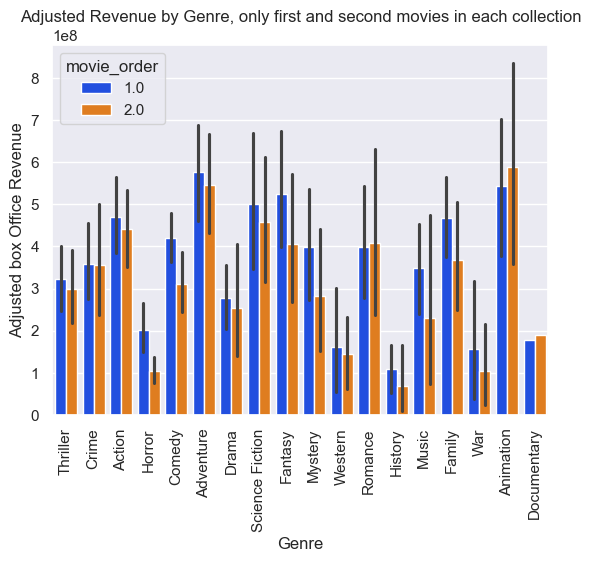

In [ ]:
f_and_s_filtered = f_and_s.groupby('collection_id').filter(lambda x: x['ratio_revenue_budget'].notna().all())
print(len(f_and_s_filtered))
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s_filtered.sort_values(by='real_revenue', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()

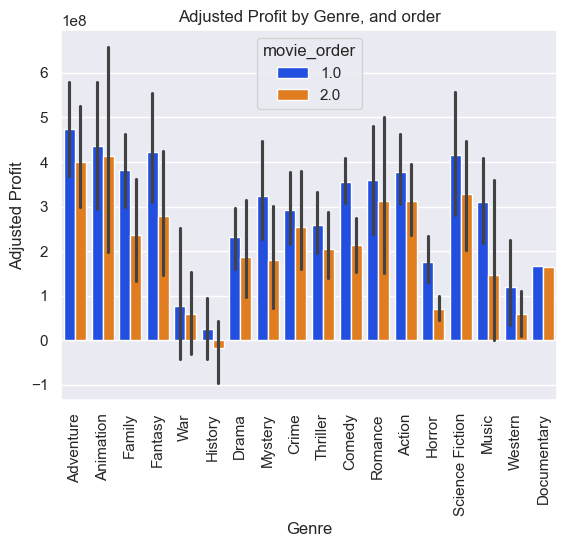

In [ ]:
ax = sns.barplot(x="genres", y="real_profit", data=f_and_s_filtered.sort_values(by='real_profit', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Adjusted Profit')
plt.xlabel('Genre')
plt.title('Adjusted Profit by Genre, and order')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Same thing here

without filtering the data

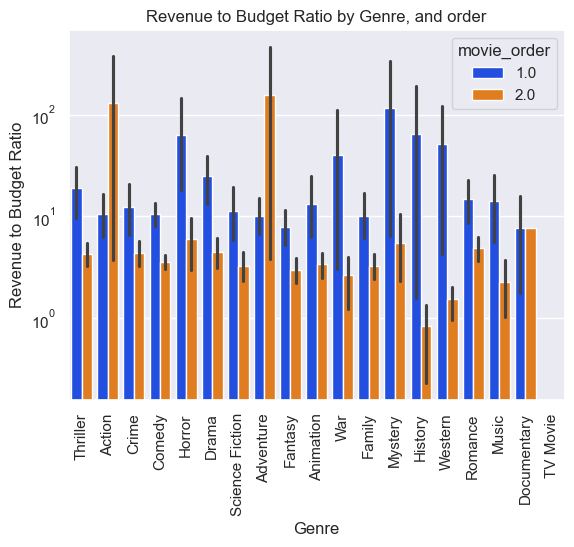

First movies :
                     Movie name    genres  ratio_revenue_budget
8871   The Blair Witch Project    Horror           4143.984983
8872   The Blair Witch Project   Mystery           4143.984983
10229      Paranormal Activity   Mystery            899.329302
10228      Paranormal Activity    Horror            899.329302
3        The Birth of a Nation     Drama            500.000000
5        The Birth of a Nation       War            500.000000
4        The Birth of a Nation   History            500.000000
1624                Open Water     Drama            420.522723
1626                Open Water    Horror            420.522723
1625                Open Water  Thriller            420.522723 
 Second movies :
                   Movie name     genres  ratio_revenue_budget
7663             Kickboxer 2  Adventure          14052.943820
7662             Kickboxer 2     Action          14052.943820
182         Dawn of the Dead     Horror             84.615385
11079  Paranormal Activi

In [ ]:
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Filter the second movies with higher ratio_revenue_budget
high_ratio_second_movies = f_and_s[(f_and_s['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s[(f_and_s['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

Action and adventure movies have higher revenue/budget ratio in second movie vs in first, but very high error bars => outlier kckboxer 2, only one of the kickboxers to have ratio to revenue

So now we use filtering

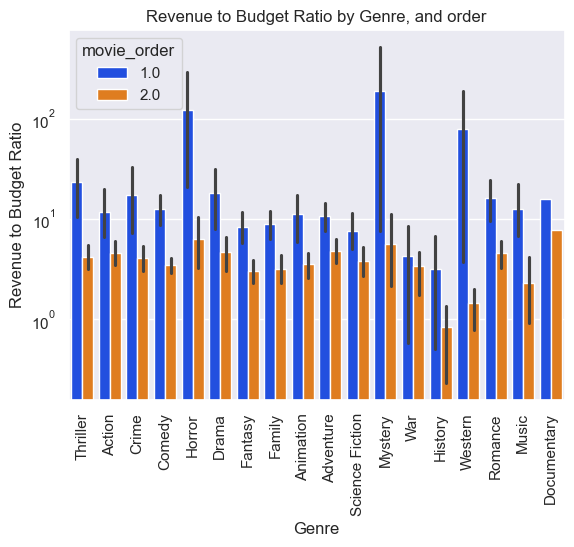

First movies :
                      Movie name    genres  ratio_revenue_budget
8872    The Blair Witch Project   Mystery           4143.984983
8871    The Blair Witch Project    Horror           4143.984983
10228       Paranormal Activity    Horror            899.329302
10229       Paranormal Activity   Mystery            899.329302
91     Night of the Living Dead    Horror            368.421053
92     Night of the Living Dead  Thriller            368.421053
736                 El Mariachi  Thriller            282.480277
734                 El Mariachi    Action            282.480277
735                 El Mariachi     Crime            282.480277
737                 El Mariachi   Western            282.480277 
 Second movies :
                                          Movie name     genres  \
182                                Dawn of the Dead     Horror   
11079                         Paranormal Activity 2    Mystery   
11078                         Paranormal Activity 2     Horror 

In [ ]:
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s_filtered.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Filter the second movies with higher ratio_revenue_budget
high_ratio_second_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

first movie works a lot better, outlier = blair witch project

### Genre and movie order

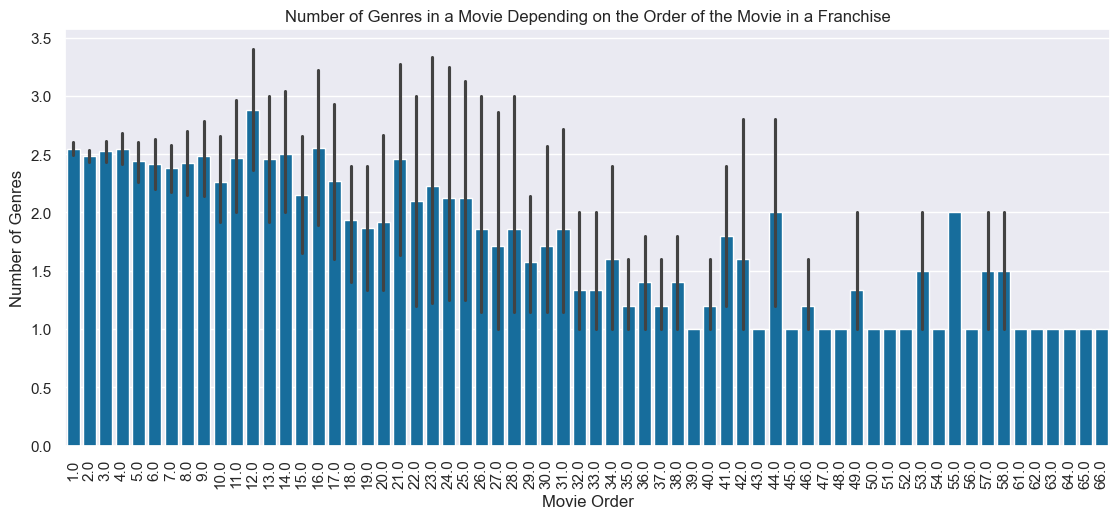

In [ ]:
# Create a bar plot of the number of genres depending on the order of the movie in a franchise
drop_no_genre = franchise_df[franchise_df['num_genres'] > 0]
plt.figure(figsize=(12, 6))
sns.barplot(x='movie_order', y='num_genres', data=drop_no_genre)

# Add labels and title
plt.xlabel('Movie Order')
plt.ylabel('Number of Genres')
plt.title('Number of Genres in a Movie Depending on the Order of the Movie in a Franchise')
# Rotate bar x-axis labels plot for better readability
plt.xticks(rotation=90)
# Adjust layout to add padding
plt.tight_layout(pad=3.0)

# Show the plot
plt.show();

We know that 75% of the franchises have between 2 and 4 movies, and here we can see that for these franchises, and for the first movies of longer franchises, the number of genres does not seem to change much. Maybe they switched though ? 
And for longer franchises, we see that the number of genres seems to decrease, and oscillate quite weirdly.
Now, let's see if the genres change between two consecutive movies

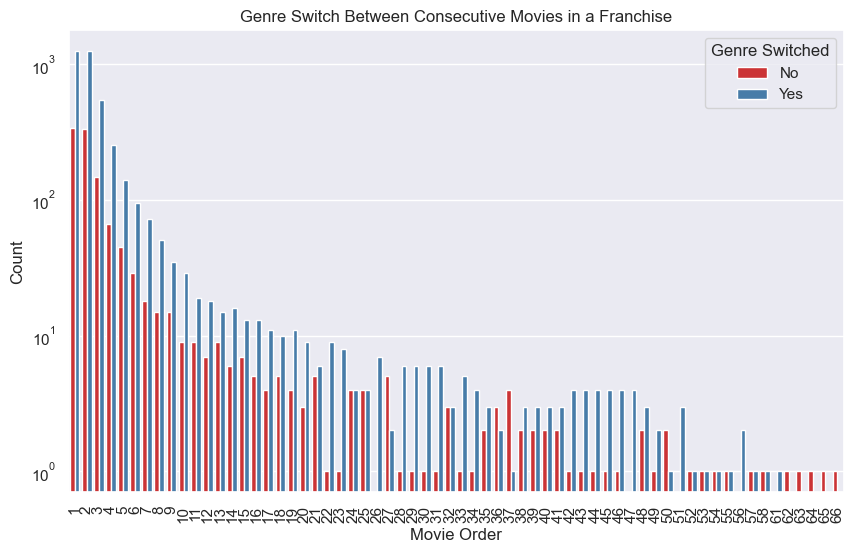

In [ ]:
# Reset the index of the DataFrame
drop_no_genre = drop_no_genre.reset_index(drop=True)

# Create a new column to indicate if the genre switched between two movies in a franchise
drop_no_genre['genre_switched'] = drop_no_genre.groupby('collection_id')['genres'].apply(lambda x: x != x.shift()).reset_index(drop=True)

# Plot for every movie in the franchise
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='movie_order', hue='genre_switched', data=drop_no_genre[['movie_order', 'genre_switched']].astype(int), palette='Set1', ax=ax)
ax.set_xlabel('Movie Order')
ax.set_ylabel('Count')
ax.set_title('Genre Switch Between Consecutive Movies in a Franchise')
ax.legend(title='Genre Switched', labels=['No', 'Yes'])
ax.set_yscale('log')
# Ensure x-axis labels are integers
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

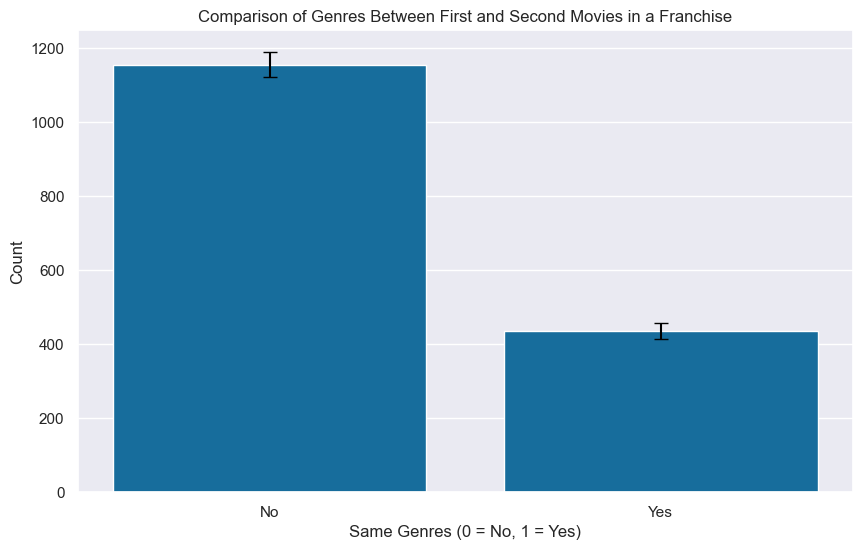

movie_order                                      1.0  \
collection_id                                          
10.0            [Adventure, Action, Science Fiction]   
84.0                             [Adventure, Action]   
119.0                   [Adventure, Fantasy, Action]   
131.0                                        [Drama]   
151.0          [Science Fiction, Adventure, Mystery]   
...                                              ...   
1368193.0                           [Family, Comedy]   
1377494.0                             [Crime, Drama]   
1379724.0                  [Drama, Horror, Thriller]   
1380844.0                      [War, Drama, History]   
1382526.0                   [Comedy, Drama, Romance]   

movie_order                                               2.0  same_genres  
collection_id                                                               
10.0                     [Adventure, Action, Science Fiction]         True  
84.0                                    

In [ ]:
# Filter the DataFrame to include only the first and second movies in each franchise
first_and_second_movies = drop_no_genre[drop_no_genre['movie_order'].isin([1, 2])]

# Pivot the DataFrame to have one row per franchise and columns for the genres of the first and second movies
pivot_df = first_and_second_movies.pivot(index='collection_id', columns='movie_order', values='genres')

# Create a new column to indicate if the genres are the same between the first and second movies
pivot_df['same_genres'] = pivot_df[1] == pivot_df[2]

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))
# Calculate the error bars
error_bars = pivot_df['same_genres'].astype(int).value_counts().apply(lambda x: math.sqrt(x))

# Plot with error bars
sns.countplot(x=pivot_df['same_genres'].astype(int), ax=ax)
ax.errorbar(x=[0, 1], y=pivot_df['same_genres'].astype(int).value_counts(), yerr=error_bars, fmt='none', c='black', capsize=5)
ax.set_xlabel('Same Genres (0 = No, 1 = Yes)')
ax.set_ylabel('Count')
ax.set_title('Comparison of Genres Between First and Second Movies in a Franchise')
ax.set_xticklabels(['No', 'Yes'])

plt.show()
print(pivot_df)

ajouter ça si possible dans une lin reg / trees etc, mais attention ! certains films ont 0 genres, mais n'ont pas le ratio non plus !
j'ai ajouté dans utils !

### Budget and revenue

#### Average revenue of a franchise and length of a franchise, frequency and number of movie 

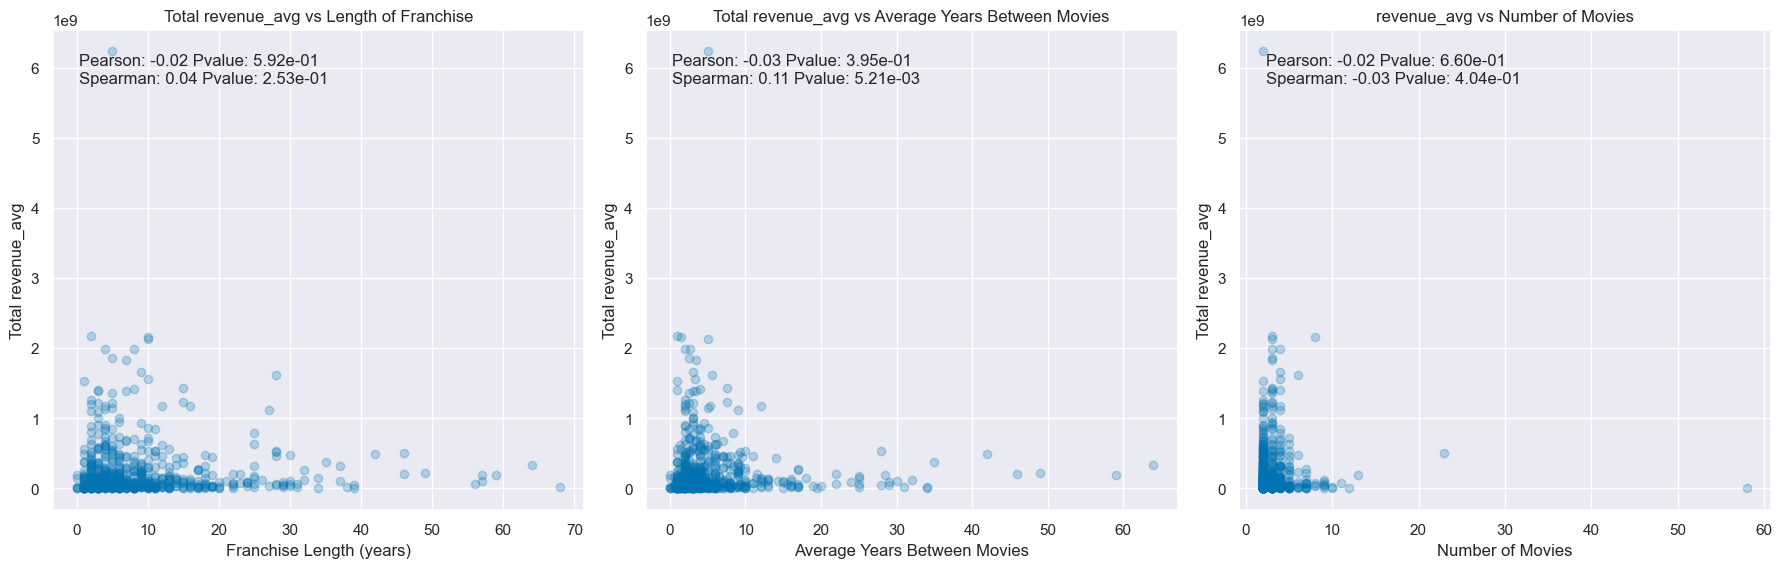

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of total revenue_avg vs length of a franchise
axes[0].scatter(franchise_data_df['franchise_length_years'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[0].set_title('Total revenue_avg vs Length of Franchise')
axes[0].set_xlabel('Franchise Length (years)')
axes[0].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs average years between movies
axes[1].scatter(franchise_data_df['average_years_bt_movies'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[1].set_title('Total revenue_avg vs Average Years Between Movies')
axes[1].set_xlabel('Average Years Between Movies')
axes[1].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs number of movies in the franchise
axes[2].scatter(franchise_data_df['movie_count'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[2].set_title('revenue_avg vs Number of Movies')
axes[2].set_xlabel('Number of Movies')
axes[2].set_ylabel('Total revenue_avg')

plt.tight_layout()

# Calculate Pearson and Spearman correlations
pearson_corr_length = stats.pearsonr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])
spearman_corr_length = stats.spearmanr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])

pearson_corr_average = stats.pearsonr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])
spearman_corr_average = stats.spearmanr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])

pearson_corr_count = stats.pearsonr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])
spearman_corr_count = stats.spearmanr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])


# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_length.statistic:.2f} Pvalue: {pearson_corr_length.pvalue:.2e}\nSpearman: {spearman_corr_length.statistic:.2f} Pvalue: {spearman_corr_length.pvalue:.2e}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_average.statistic:.2f} Pvalue: {pearson_corr_average.pvalue:.2e}\nSpearman: {spearman_corr_average.statistic:.2f} Pvalue: {spearman_corr_average.pvalue:.2e}',
             transform=axes[1].transAxes, verticalalignment='top')

axes[2].text(0.05, 0.95, f'Pearson: {pearson_corr_count.statistic:.2f} Pvalue: {pearson_corr_count.pvalue:.2e}\nSpearman: {spearman_corr_count.statistic:.2f} Pvalue: {spearman_corr_count.pvalue:.2e}',
             transform=axes[2].transAxes, verticalalignment='top')

plt.show()

We don't observe a significant correlation, but there seems to be a range where the high budget movies lies in.

#### Box office of a movie and the average vote of a movie vs the year difference between the movies

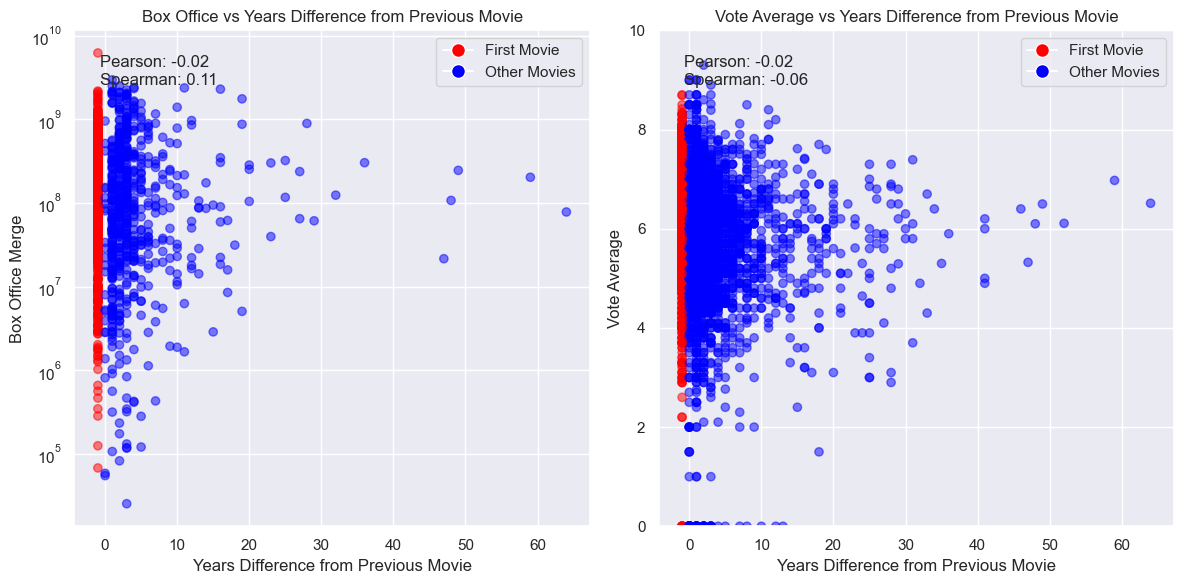

In [ ]:
# Create a copy of the franchise data since modification will be made
franchise_df_temp = franchise_df.copy()

# Replace NaN values in 'years_diff_bt_pre_movies' with -1
franchise_df_temp['years_diff_bt_pre_movies'].fillna(-1, inplace=True)

# Create a color map for the scatter plot
colors = franchise_df_temp['years_diff_bt_pre_movies'].apply(lambda x: 'red' if x == -1 else 'blue')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of years difference vs box office merge
axes[0].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['real_revenue'], c=colors, alpha=0.5)
axes[0].set_title('Box Office vs Years Difference from Previous Movie')
axes[0].set_xlabel('Years Difference from Previous Movie')
axes[0].set_ylabel('Box Office Merge')
axes[0].set_yscale('log')

# Scatter plot of years difference vs vote average
axes[1].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['vote_average'], c=colors, alpha=0.5)
axes[1].set_title('Vote Average vs Years Difference from Previous Movie')
axes[1].set_xlabel('Years Difference from Previous Movie')
axes[1].set_ylabel('Vote Average')
axes[1].set_ylim(0, 10)

# Add legend to the plot
first_movie_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='First Movie')
other_movies_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Other Movies')
axes[0].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')
axes[1].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')

plt.tight_layout()

# Filter out rows where 'years_diff_bt_pre_movies' is -1
filtered_franchise_df_temp = franchise_df_temp[franchise_df_temp['years_diff_bt_pre_movies'] != -1]

# Calculate Pearson and Spearman correlations
pearson_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='spearman').iloc[0, 1]

pearson_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='spearman').iloc[0, 1]

# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_box_office:.2f}\nSpearman: {spearman_corr_years_diff_box_office:.2f}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_vote_average:.2f}\nSpearman: {spearman_corr_years_diff_vote_average:.2f}', 
             transform=axes[1].transAxes, verticalalignment='top')

plt.show()


Note that the first movies were assigned the value -1 to differentiate them from the rest of the movies but still have them on the plot (they are not taking into account for the correlation). We observe no significant correlation for both 

## Shapley value analysis: what is the recipe for franchise movies?

In [103]:
tree_df = get_tree_df(franchise_df, movies_no_franchise_df, RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(tree_df.drop(columns=["in_franchise"]), tree_df["in_franchise"], test_size=0.3)
clf = HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print("Test accuracy:", clf.score(X_test, y_test))

Test accuracy: 0.8294979079497908


In [104]:
run_importance(clf, X_train, X_test, y_test, target_name="in_franchise", save_dir="data/shapley_result", random_state=RANDOM_STATE)

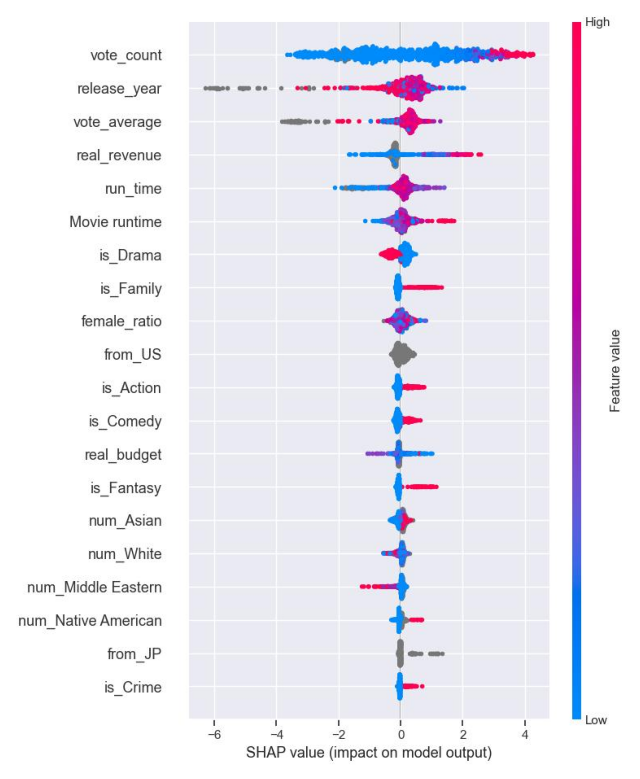

In [106]:
shap_plot = plt.imread("data/shapley_result/shap_summary_plot_in_franchise.jpg")
plt.figure(figsize=(8,10))  # Set the plot size
plt.imshow(shap_plot)
plt.axis('off')  # Hide the axis
plt.show()